In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_rows = 1000 # this will set limit of rows to 500

# LandScan population statistics for day and nighttime, aggregated to hexes
hexes     = gpd.read_file('../data/shapefiles/nyc/population_hexbinned.geojson')

# table of in-/out-flow taxi rides per taxi zone, hour/day/month
rides     = pd.read_csv('../data/tables/fhv19.csv')

# taxi zone shapefile
tz        = gpd.read_file('../data/shapefiles/nyc/taxi_zones.geojson')\
               .to_crs(hexes.crs)
keep_cols = ['location_id', 'zone', 'geometry']
tz        = tz[keep_cols] # filter columns

# renaming tz column and resetting type to int
tz.rename(columns={'location_id': 'taxizoneID'},inplace=True)
tz['taxizoneID'] = tz['taxizoneID'].astype(int)

# fixing data duplication error in the TZ data-set
tz.iloc[56, tz.columns.get_loc('taxizoneID')] = 57
tz.iloc[103, tz.columns.get_loc('taxizoneID')] = 104
tz.iloc[104, tz.columns.get_loc('taxizoneID')] = 105

In [10]:
rides['month']  = rides.apply(lambda row: row['time'].split('/')[0], axis=1)
rides['day']    = rides.apply(lambda row: row['time'].split('/')[1], axis=1)
rides['night?'] = rides.apply(lambda row: 0 if row['timegroupstr'] == 'daytime' else 1, axis=1)

rides['month']  = rides['month'].astype(int)
rides['day']    = rides['day'].astype(int)
rides['night?'] = rides['night?'].astype(int)

In [11]:
# pivot table to sum day/night rides by taxi zone, day, and month
table = pd.pivot_table(rides,
                       values=['inflow_counts', 'outflow_counts'],
                       index=['taxizoneID', 'month', 'day', 'weekday', 'night?'],
                       aggfunc=np.sum).reset_index()

In [12]:
print(f"{table.shape[0]} total records in the rides dataset.")
print(f"{len(table.taxizoneID.unique())} total taxi zones represented over "
     + f"{len(table.month.unique())} months in 2019.")
print()
table.head()

63383 total records in the rides dataset.
263 total taxi zones represented over 5 months in 2019.



,taxizoneID,month,day,weekday,night?,inflow_counts,outflow_counts
0,1,1,1,Tuesday,0,4038,153
1,1,1,1,Tuesday,1,234,85
2,1,1,2,Wednesday,0,3821,139
3,1,1,2,Wednesday,1,284,72
4,1,1,3,Thursday,0,2702,76


In [17]:
tz_merged = tz.merge(table, on='taxizoneID', how='right')

tz_merged.head()

,taxizoneID,zone,geometry,month,day,weekday,night?,inflow_counts,outflow_counts
0,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,1,Tuesday,0,4038,153
1,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,1,Tuesday,1,234,85
2,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,2,Wednesday,0,3821,139
3,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,2,Wednesday,1,284,72
4,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,3,Thursday,0,2702,76


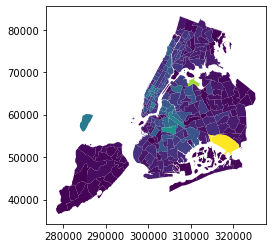

In [26]:
tz_merged[(tz_merged['month'] == 1) &\
          (tz_merged['day'] == 1) &\
          (tz_merged['night?'] == 0)].plot(column='inflow_counts');

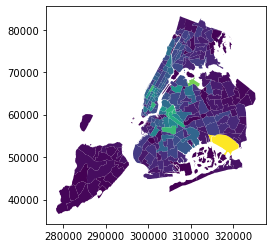

In [28]:
tz_merged[(tz_merged['month'] == 1) &\
          (tz_merged['day'] == 1) &\
          (tz_merged['night?'] == 0)].plot(column='outflow_counts');